# OSCAR, a Tech Preview (Part II)
## Wronski Polynomial Systems

Soprunova & Sottile: Lower bounds for real solutions to sparse polynomial systems, <i>Adv. Math.</i> <b>204</b> (2006).

In [1]:
using Polymake, Singular, Nemo

polymake version 3.5
Copyright (c) 1997-2019
Ewgenij Gawrilow, Michael Joswig (TU Berlin)
https://polymake.org

This is free software licensed under GPL; see the source for copying conditions.
There is NO warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.


Welcome to Nemo version 0.16.1

Nemo comes with absolutely no warranty whatsoever



We will consider certain systems of polynomial equations which require a regular triangulation of a lattice polytope as (part of its) input.

In [2]:
M = Polymake.Polytope.lattice_points(Polymake.Polytope.simplex(2,3))
λ = [12,3,0,0,8,1,0,9,5,15];
F = Polymake.Polytope.regular_subdivision(M, λ)
TT = @pm Fan.SubdivisionOfPoints(POINTS = M, MAXIMAL_CELLS = F)

polymake: used package ppl
  The Parma Polyhedra Library ([[wiki:external_software#PPL]]): A C++ library for convex polyhedra
  and other numerical abstractions.
  http://www.cs.unipr.it/ppl/



type: SubdivisionOfPoints<Rational>

POINTS
1 0 0
1 0 1
1 0 2
1 0 3
1 1 0
1 1 1
1 1 2
1 2 0
1 2 1
1 3 0


MAXIMAL_CELLS
{0 1 4}
{1 4 5}
{1 2 5}
{2 5 6}
{2 3 6}
{4 5 7}
{5 7 8}
{5 6 8}
{7 8 9}

In [3]:
Polymake.Fan.visual(TT)

polymake: used package cdd
  cddlib
  Implementation of the double description method of Motzkin et al.
  Copyright by Komei Fukuda.
  http://www-oldurls.inf.ethz.ch/personal/fukudak/cdd_home/



<!--
polymake for joswig
Fri Jan 24 14:41:10 2020
pcom:
-->


 
 
 pcom: 
 
 

 

 
 
 Explode 
 
 Automatic explosion 
 Exploding speed 
 
 

 
 
 Transparency 
 
 
 
 
 Rotation 
 
 x-axis 
 y-axis 
 z-axis 
 Reset 
 

 Rotation speed 
 

 


 
 Display 
 
 
 Labels 
 
 


 
 SVG 
 
 
 Download 
 New tab 
 
 Screenshot 
 
 

 <!-- end of settings -->

polymake: used package threejs
   Three.js is a lightweight cross-browser JavaScript library/API used to create and display animated 3D computer graphics on a Web browser.
   See http://github.com/mrdoob for the source code.



This triangulation is very special in that it is <i>foldable</i> (or "balanced"), i.e., the dual graph is bipartite.  This means that the triangles can be colored, say, black and white such that no two triangles of the same color share an edge.  The <i>signature</i> is the absolute difference of the black triangles minus the white triangles (of odd normalized volume).

In [4]:
T = @pm Topaz.GeometricSimplicialComplex(COORDINATES = M[:,2:end], FACETS = F)
@show T.FOLDABLE
@show T.SIGNATURE

T.FOLDABLE = true
T.SIGNATURE = 3


3

This ideal will be relevant later to check a certain condition, involving the triangulation and some lifting function.  The implementation uses Singular and polymake.

In [5]:
function wronski_center_ideal(L::AbstractMatrix, λ::AbstractVector)
    d = size(L, 2) - 1
    N = size(L, 1)
    
    T = @pm Topaz.SimplicialComplex(FACETS=Polymake.Polytope.regular_subdivision(L, λ))
    
    proj_orbits = @pm Common.convert_to{Array{Set{Int}}}(T.PROJ_ORBITS)
    
    colors = Dict([first(o) => i for (i, o) in enumerate(proj_orbits)])
    points_by_color = [Int[] for _ in 0:d]
    for (i, c) in enumerate(T.PROJ_DICTIONARY)
        push!(points_by_color[colors[c]], i)
    end
    
    vars = [["x$i" for i in 1:d]; "s"] # elimination ordering
    R, X = Singular.PolynomialRing(Singular.QQ, vars, ordering = :lex)
    
    # create generators
    monomials = [L[:,2:end] λ]
    Singular.Ideal(R, map(points_by_color) do pts
        M = monomials[pts, :]
        sum(prod(X[j]^Int(M[i, j]) for j in 1:d+1) for i in 1:size(M, 1))
    end)
end

wronski_center_ideal (generic function with 1 method)

It is a fact that the vertices of a foldable triangulation can be colored by $d+1$ colors (such that vertices of the same color do not share an edge), where $d$ is the dimension.  Here $d=2$.

Now a <i>Wronski polynomial</i> has the given lattice points as exponents, and only one coefficient per color class of vertices of the triangulation.

In [6]:
function wronski_polynomial(
        M, λ, coeffs, s, X;
        triangulation = @pm Topaz.SimplicialComplex(FACETS=Polymake.Polytope.regular_subdivision(M, λ))
)        
    n = size(M, 1)
    d = size(M, 2)  - 1
    T = triangulation
    m = Dict(f[1] => i for (i, f) in enumerate(T.FACETS[1]))
    full_coeffs = [s^Int(λ[i]) * coeffs[m[T.PROJ_DICTIONARY[i]]] for (i, λᵢ) in enumerate(λ)]
    sum(full_coeffs[i] * prod(X[j]^Int(M[i, j + 1]) for j in 1:d) for i in 1:size(M, 1))
end

wronski_polynomial (generic function with 1 method)

A <i>Wronski system</i> consists of $d$ Wronski polynomials with respect to the same lattice points and triangulation.  It is assumed that the coefficients are generic.

In [7]:
function wronski_system(M, λ, coeffs_vec, s, X;
    triangulation = Polymake.Topaz.SimplicialComplex(FACETS=Polymake.Polytope.regular_subdivision(M, λ))
)
    map(c -> wronski_polynomial(M, λ, c, s, X; triangulation = triangulation), coeffs)
end

wronski_system (generic function with 1 method)

The Wronski center ideal is generated by $d+1$, here 3, polynomials which collect the terms of the color classes and a new variable, $s$, for the lifting function.

In [8]:
I = wronski_center_ideal(M, λ)
Singular.gens(I)

┌ Warning: The return value contains pm::PowerSet<int, pm::operations::cmp> which has not been wrapped yet;
│ use `@pm Common.convert_to{wrapped_type}(...)` to convert to julia-understandable type.
└ @ Polymake /home/joswig/.julia/packages/Polymake/RJHSX/src/functions.jl:66


3-element Array{spoly{n_Q},1}:
 x1^3*s^15+x1*x2*s+x2^3+s^12
 x1^2*s^9+x1*x2^2+x2*s^3    
 x1^2*x2*s^5+x1*s^8+x2^2    

We compute a Gröbner basis with respect to the lex-ordering.  As this is an elimination ordering, the first polynomial is the eliminant, which is a univariate polynomial in $s$.

In [9]:
e = first(Singular.gens(Singular.std(I)))

s^33-3*s^32-6*s^31-s^30+3*s^23-s^15

Via Nemo we get a univariate polynomial ring with complex coefficients, which are floating point number with arbitrary precision.

In [10]:
CC, s = Nemo.PolynomialRing(ComplexField(256), "s")

(Univariate Polynomial Ring in s over Complex Field with 256 bits of precision and error bounds, [ 0 + i*0, 1.00000000000000000000000000000000000000000000000000000000000000000000000000000 + i*0 ])

We are interested in toric solutions; hence we may divide the eliminant by $s^{15}$.

In [11]:
c = Rational{BigInt}.(Singular.coeffs(e))
exps = last.(Singular.exponent_vectors(e))

# Ignore 0 solutions
exps .-= minimum(exps)

6-element Array{Int64,1}:
 18
 17
 16
 15
  8
  0

We get 18 complex roots, out of which two are real.  One of the conditions to check asks that there are no real roots between $0$ and $1$.  See the Soprunova-Sottile paper for details.

In [12]:
roots(sum(c.* s.^exps))

18-element Array{acb,1}:
 [-0.8952190 +/- 6.00e-8] + i*0                       
 [4.4114706 +/- 7.09e-8] + i*0                        
 [0.8642667 +/- 4.17e-8] + i*[0.1138001 +/- 5.80e-8]  
 [0.8642667 +/- 4.17e-8] + i*[-0.1138001 +/- 5.80e-8] 
 [-1.148254 +/- 1.75e-7] + i*[-0.170267 +/- 5.59e-7]  
 [-1.148254 +/- 1.75e-7] + i*[0.170267 +/- 5.59e-7]   
 [0.693192 +/- 3.22e-7] + i*[-0.531577 +/- 7.27e-7]   
 [0.693192 +/- 3.22e-7] + i*[0.531577 +/- 7.27e-7]    
 [-0.665573 +/- 3.33e-7] + i*[0.589893 +/- 7.64e-7]   
 [-0.665573 +/- 3.33e-7] + i*[-0.589893 +/- 7.64e-7]  
 [0.535093 +/- 5.79e-7] + i*[-0.689931 +/- 5.92e-7]   
 [0.535093 +/- 5.79e-7] + i*[0.689931 +/- 5.92e-7]    
 [-0.565675 +/- 7.93e-7] + i*[0.748473 +/- 6.58e-7]   
 [-0.565675 +/- 7.93e-7] + i*[-0.748473 +/- 6.58e-7]  
 [-0.0907984 +/- 6.04e-8] + i*[-0.8742440 +/- 3.72e-8]
 [-0.0907984 +/- 6.04e-8] + i*[0.8742440 +/- 3.72e-8] 
 [0.1196228 +/- 2.73e-8] + i*[-0.8809379 +/- 2.90e-8] 
 [0.1196228 +/- 2.76e-8] + i*[0.8809379 

The main result of their paper says that, if all the conditions are satisfied, then a Wronski system has at least signature many real solutions.

In [13]:
import HomotopyContinuation
HomotopyContinuation.@polyvar x[1:2]

coeffs = [[19,8,-19],[39,7,42]]
W = wronski_system(M, λ, coeffs, 1, x; triangulation = T)

2-element Array{DynamicPolynomials.Polynomial{true,Int64},1}:
 19x₁³ - 19x₁²x₂ + 8x₁x₂² + 19x₂³ + 8x₁² + 19x₁x₂ - 19x₂² - 19x₁ + 8x₂ + 19
 39x₁³ + 42x₁²x₂ + 7x₁x₂² + 39x₂³ + 7x₁² + 39x₁x₂ + 42x₂² + 42x₁ + 7x₂ + 39

In [14]:
result = HomotopyContinuation.solve(W)

Result{Array{Complex{Float64},1}} with 9 solutions
• 9 non-singular solutions (3 real)
• 0 singular solutions (0 real)
• 9 paths tracked
• random seed: 726961


In [15]:
HomotopyContinuation.real_solutions(result)

3-element Array{Array{Float64,1},1}:
 [-0.6784171390232674, -0.9983349340221539]
 [1.4715650248156755, -1.4740193643098745] 
 [-1.0016678430465593, 0.679548632331254]  

## Visualization (using Sascha's very fresh code)

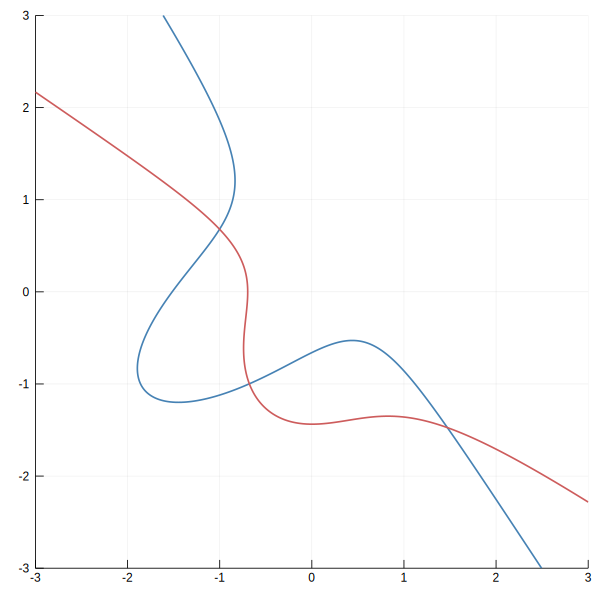

In [16]:
using ImplicitPlots
p1 = implicit_plot(W[1])
ImplicitPlots.implicit_plot!(p1, W[2]; color=:indianred)